<a href="https://colab.research.google.com/github/MOHAMMEDAWEZALI2303A51767/Data-science/blob/main/ieee_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Visualization


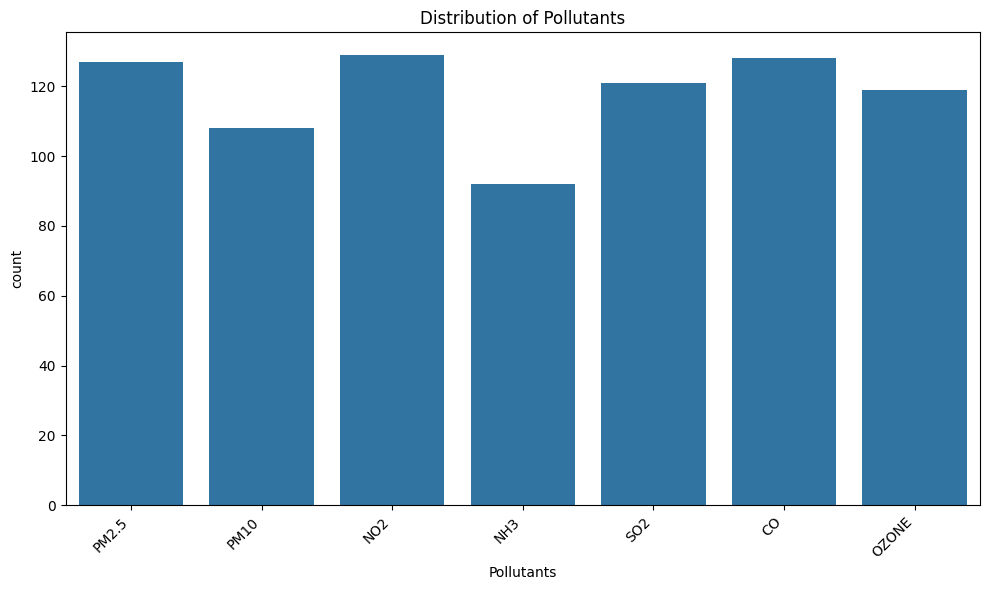

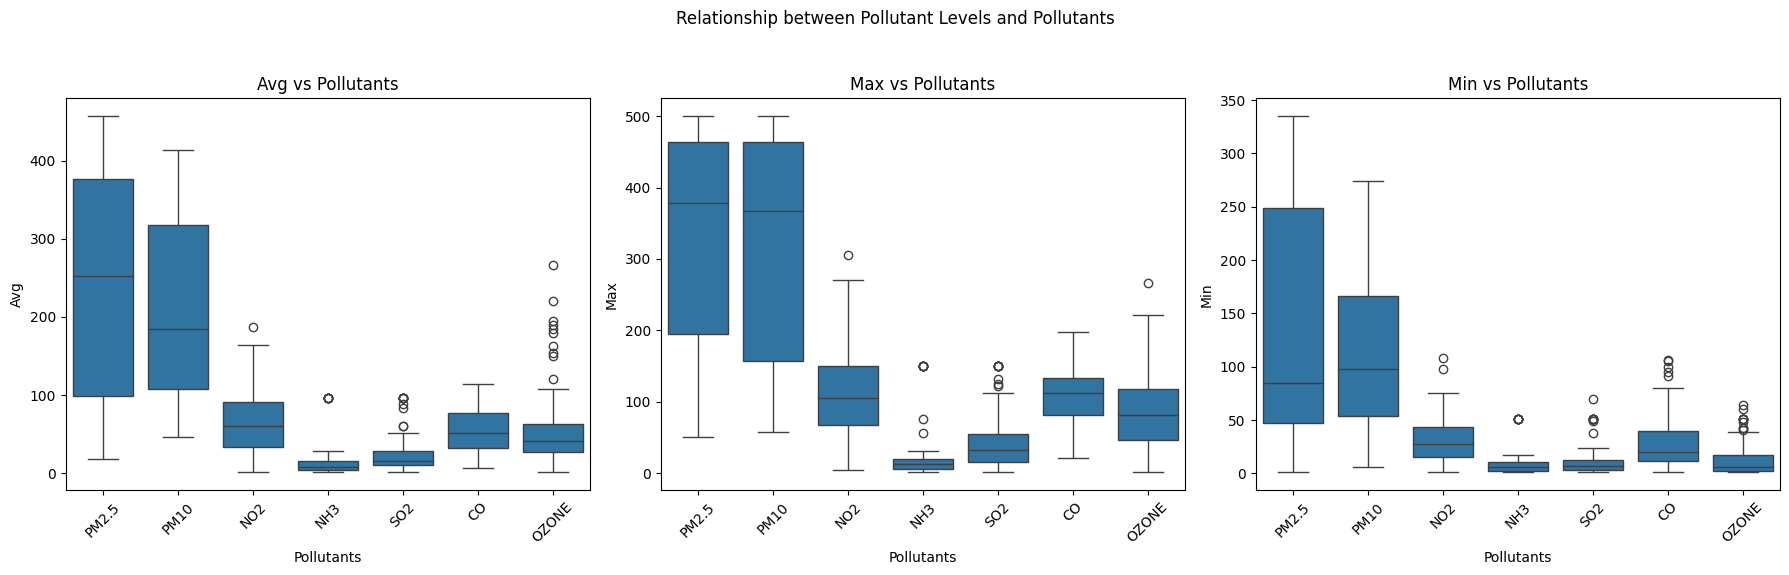


Converting 'lastupdate' to datetime...


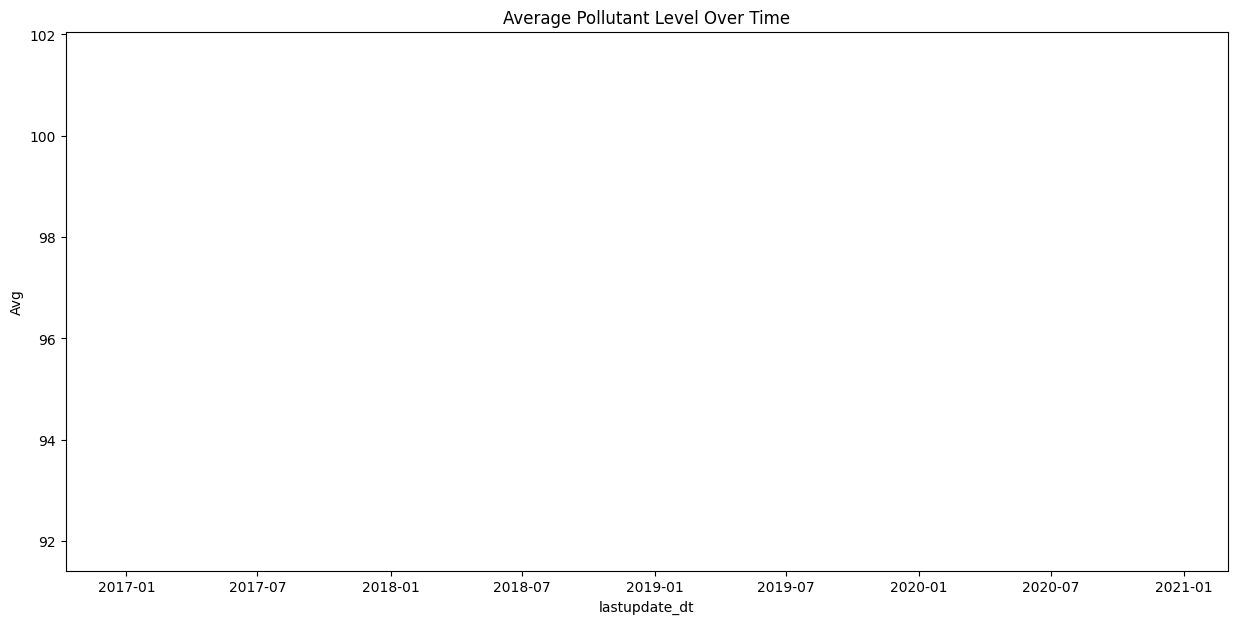

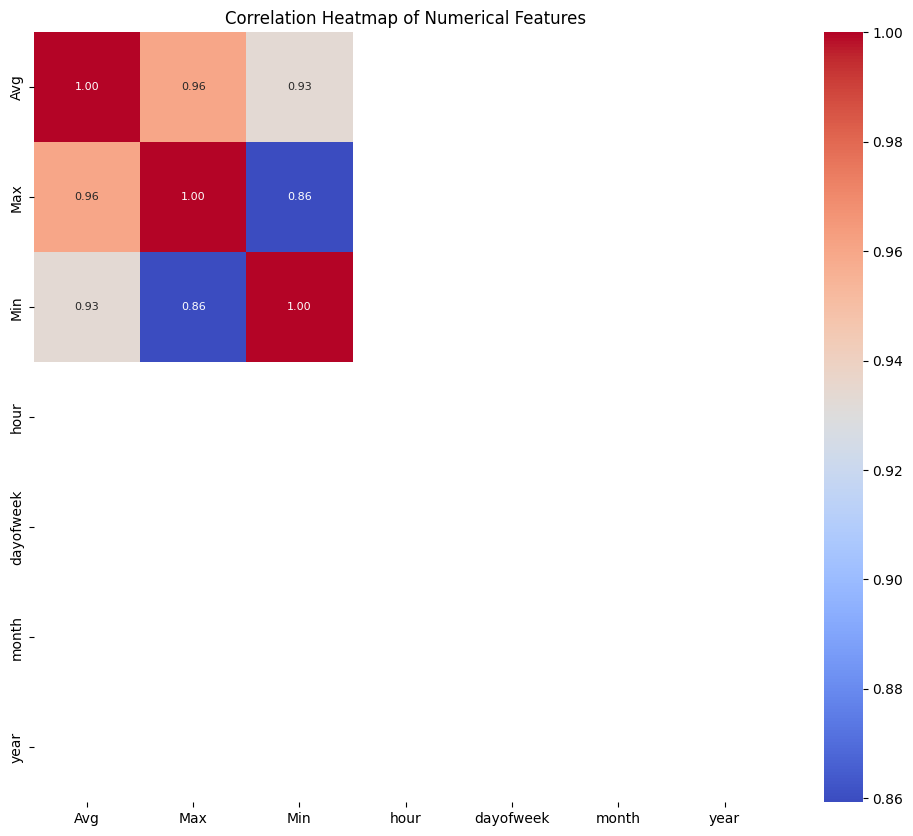


## Feature Engineering

Training Logistic Regression...
Logistic Regression Accuracy: 0.4667


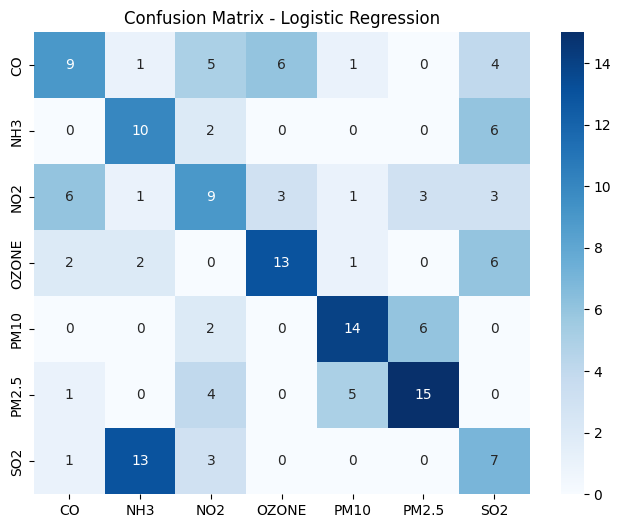

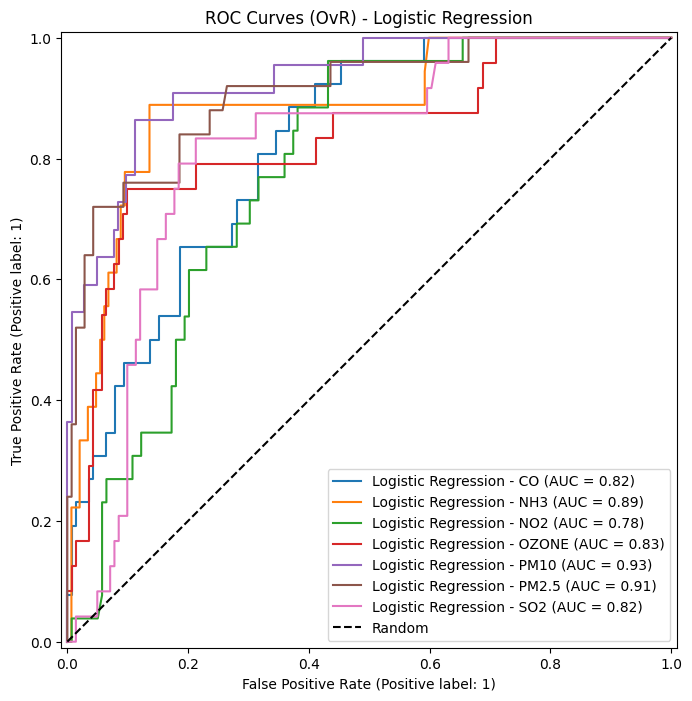


Training Decision Tree...
Decision Tree Accuracy: 0.4121


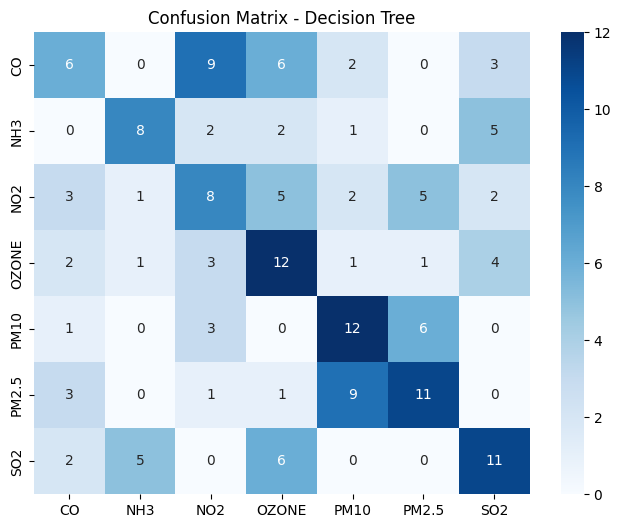

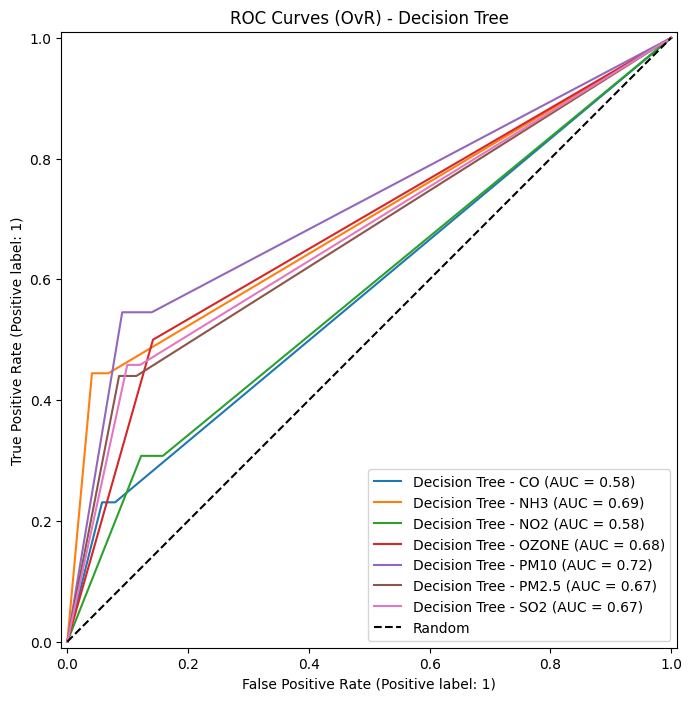


Training Random Forest...
Random Forest Accuracy: 0.4970


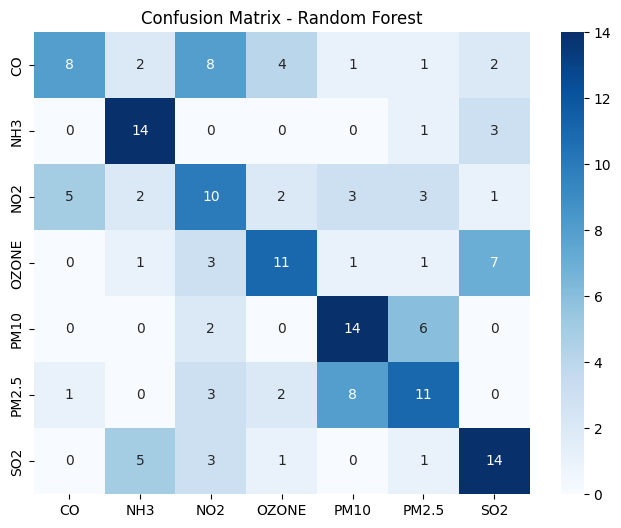

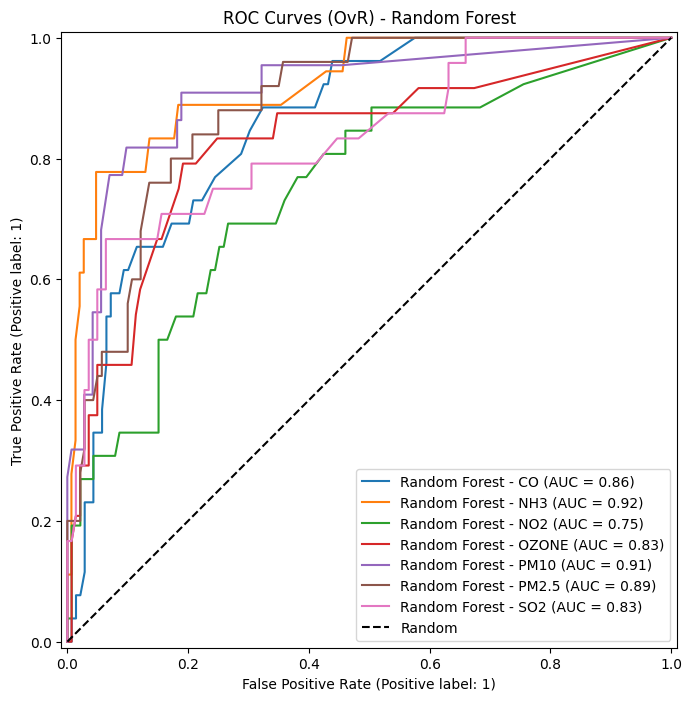


Training K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.3091


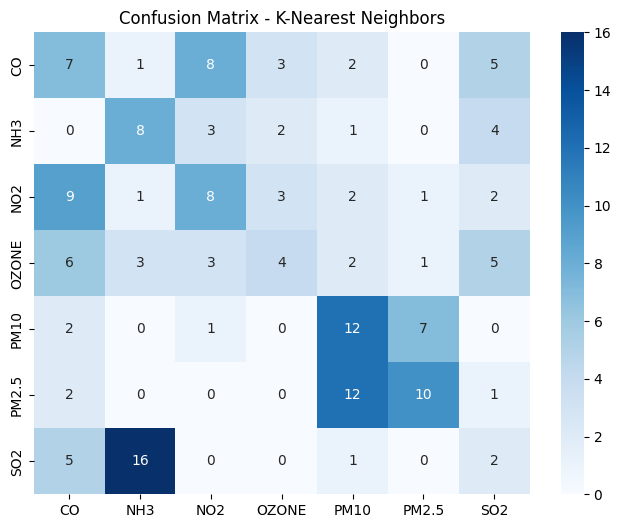

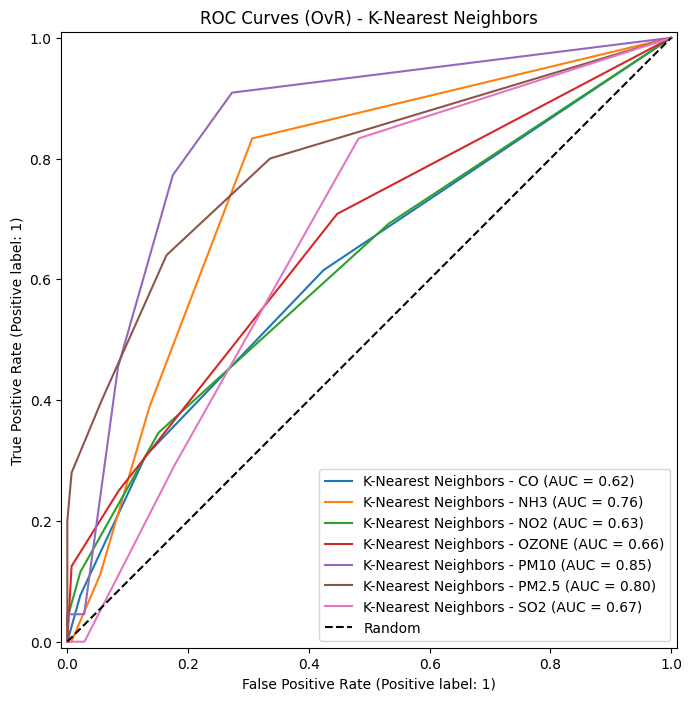


Training Support Vector Machine...
Support Vector Machine Accuracy: 0.4424


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


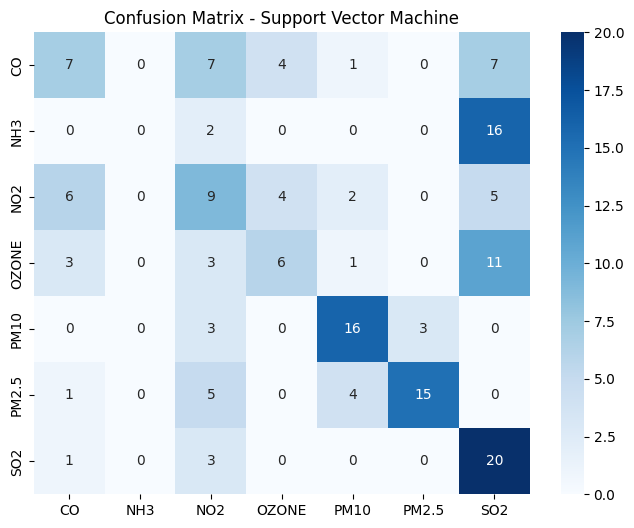

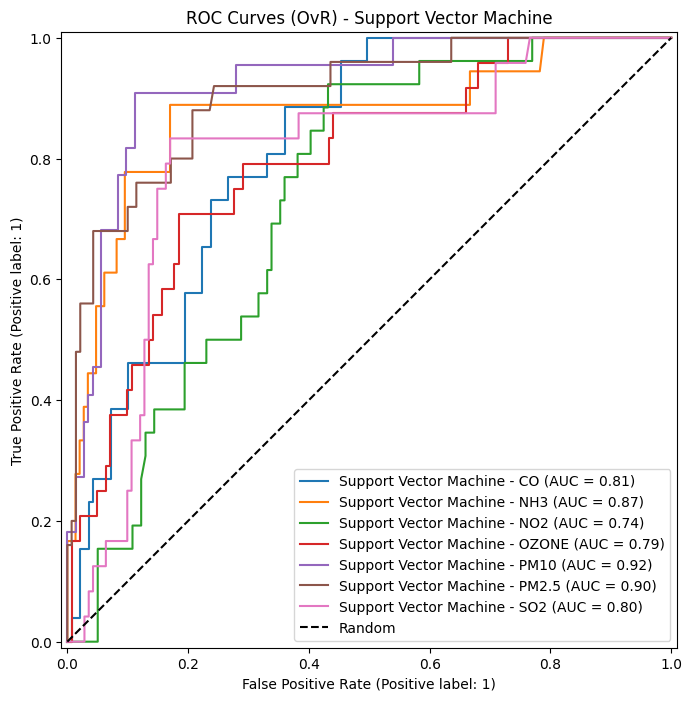

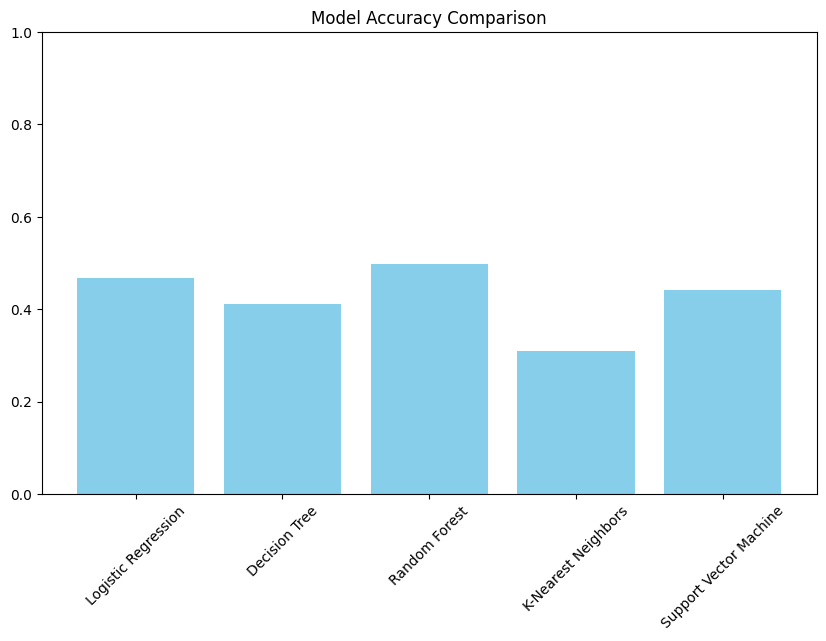

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Tuned RF Accuracy: 0.503030303030303

Top 5 Important Features:
Max_Min_Interaction    0.110270
Max_Sq                 0.102066
Avg_Max_Interaction    0.098729
Max                    0.098060
Avg_Min_Interaction    0.094110
dtype: float64


In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Read Dataset
try:
    df = pd.read_csv("/content/AirQuality.csv")
except FileNotFoundError:
    print("Error: 'AirQuality.csv' not found. Please upload the dataset to /content/ or provide the correct path.")
    raise

# Step 3: Explore Dataset (Visualizations)
print("## Data Visualization")

# Handle Missing Values (Imputation)
for col in ['Avg', 'Max', 'Min']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())

# Graph 1: Distribution of Pollutants
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Pollutants')
plt.title('Distribution of Pollutants')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Graph 2: Box Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Relationship between Pollutant Levels and Pollutants')

sns.boxplot(ax=axes[0], data=df, x='Pollutants', y='Avg')
axes[0].set_title('Avg vs Pollutants')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[1], data=df, x='Pollutants', y='Max')
axes[1].set_title('Max vs Pollutants')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[2], data=df, x='Pollutants', y='Min')
axes[2].set_title('Min vs Pollutants')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Convert 'lastupdate' to datetime and extract temporal features
print("\nConverting 'lastupdate' to datetime...")
try:
    df['lastupdate_dt'] = pd.to_datetime(df['lastupdate'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
    is_timeseries_suitable = not df['lastupdate_dt'].isnull().all()

    if is_timeseries_suitable:
        df['hour'] = df['lastupdate_dt'].dt.hour
        df['dayofweek'] = df['lastupdate_dt'].dt.dayofweek
        df['month'] = df['lastupdate_dt'].dt.month
        df['year'] = df['lastupdate_dt'].dt.year

except Exception as e:
    print(f"Could not convert 'lastupdate': {e}")
    is_timeseries_suitable = False

# Graph 3: Time Series Plot
if is_timeseries_suitable:
    df_daily_avg = df.set_index('lastupdate_dt').resample('D')['Avg'].mean().reset_index()
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=df_daily_avg, x='lastupdate_dt', y='Avg')
    plt.title('Average Pollutant Level Over Time')
    plt.show()

# Graph 4: Correlation Heatmap
numerical_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Step 4: Feature Engineering
print("\n## Feature Engineering")
df['Avg_Max_Interaction'] = df['Avg'] * df['Max']
df['Avg_Min_Interaction'] = df['Avg'] * df['Min']
df['Max_Min_Interaction'] = df['Max'] * df['Min']

df['Avg_Sq'] = df['Avg']**2
df['Max_Sq'] = df['Max']**2
df['Min_Sq'] = df['Min']**2

# Step 5: Handle Categorical Data
for col in df.select_dtypes(include=["object"]).columns:
    if col != 'Pollutants':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Step 6: Split Features and Target
X = df.drop(columns=["Pollutants", 'lastupdate', 'lastupdate_dt'], errors='ignore')
y = df["Pollutants"]

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Step 8: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True, random_state=42)
}

# Step 10: Train & Evaluate Models
evaluation_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    if name in ["Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    evaluation_results[name] = {"Accuracy": acc, "Confusion Matrix": conf_matrix, "Classification Report": class_report}
    print(f"{name} Accuracy: {acc:.4f}")

    # Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_y.classes_, yticklabels=le_y.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # ROC Curve
    if y_prob is not None and y_prob.shape[1] > 1:
        y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
        plt.figure(figsize=(10, 8))
        for i, class_id in enumerate(np.unique(y_test)):
            class_label = le_y.inverse_transform([class_id])[0]
            RocCurveDisplay.from_predictions(y_test_binarized[:, i], y_prob[:, i], name=f'{name} - {class_label}', ax=plt.gca())
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.legend()
        plt.title(f'ROC Curves (OvR) - {name}')
        plt.show()

# Model Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(evaluation_results.keys(), [v["Accuracy"] for v in evaluation_results.values()], color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

# Step 11: Hyperparameter Tuning for Random Forest
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_rf_model_tuned = grid_search.best_estimator_
y_pred_best_rf = best_rf_model_tuned.predict(X_test)
print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_best_rf))

# Step 12: Feature Importances
if hasattr(best_rf_model_tuned, 'feature_importances_'):
    feature_importances = pd.Series(best_rf_model_tuned.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("\nTop 5 Important Features:")
    print(feature_importances.head())
